In [3]:
import os
os.environ["PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION"] = "python"
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

print("Environment configured for Kaggle runtime.")


Environment configured for Kaggle runtime.


In [5]:
import numpy as np
import pandas as pd
import os, gc
import cv2
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import Xception
from tensorflow.keras.applications.xception import preprocess_input
from tensorflow.keras import layers, models

from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, classification_report

print("TensorFlow Version:", tf.__version__)

TensorFlow Version: 2.18.0


In [6]:

IMG_DIR = "/kaggle/input/drtid-data/DRTiD/Original Images"
TRAIN_CSV = "/kaggle/input/drtid-data/DRTiD/Ground Truths/DR_grade/a. DR_grade_Training.csv"
TEST_CSV  = "/kaggle/input/drtid-data/DRTiD/Ground Truths/DR_grade/b. DR_grade_Testing.csv"

IMG_SIZE = (299, 299)         
BATCH_SIZE = 16
SEED = 42


# LOAD CSVs & EXPAND (Macula + Optic as separate images)

In [8]:



train_raw = pd.read_csv(TRAIN_CSV)
test_raw  = pd.read_csv(TEST_CSV)

def expand_df(df):
    # Macula images
    mac = pd.DataFrame({
        "filename": df["Macula"].astype(str) + ".jpg",
        "label":    (df["Grade"] > 0).astype(int)
    })
    # Optic images
    optic = pd.DataFrame({
        "filename": df["Optic disc"].astype(str) + ".jpg",
        "label":    (df["Grade"] > 0).astype(int)
    })
    full = pd.concat([mac, optic], ignore_index=True)
    return full

train_df = expand_df(train_raw)
test_df  = expand_df(test_raw)

print("Train rows (after expand):", len(train_df))
print("Test rows  (after expand):", len(test_df))
train_df.head()


Train rows (after expand): 2000
Test rows  (after expand): 1100


,filename,label
0,0002_1.jpg,0
1,0003_1.jpg,1
2,0004_1.jpg,1
3,0005_1.jpg,1
4,0006_1.jpg,1


# EDA – Class Distribution & Sample Images


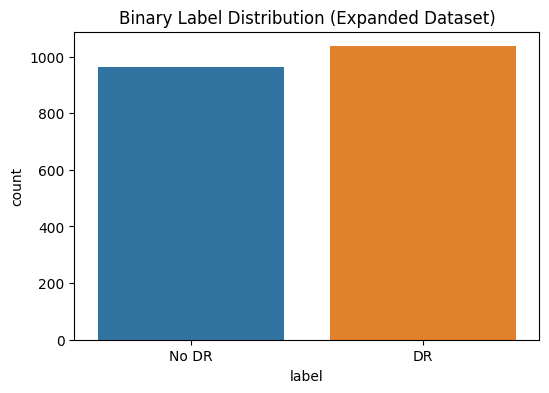


Counts:
label
1    1036
0     964
Name: count, dtype: int64


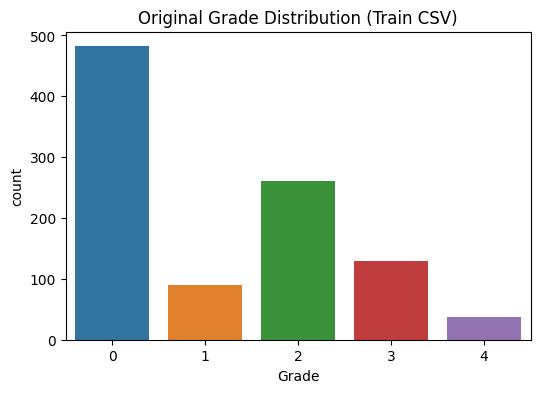

Grade
0    482
2    260
3    130
1     90
4     38
Name: count, dtype: int64


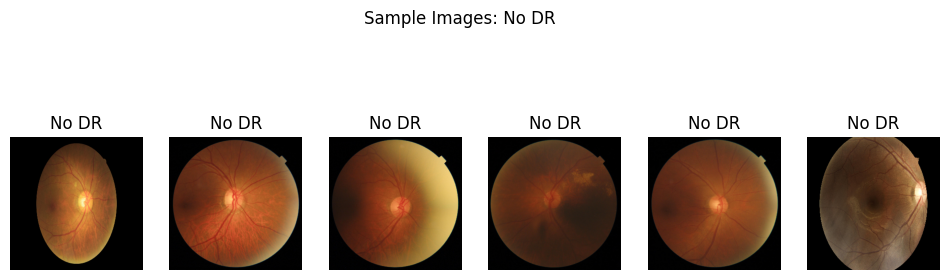

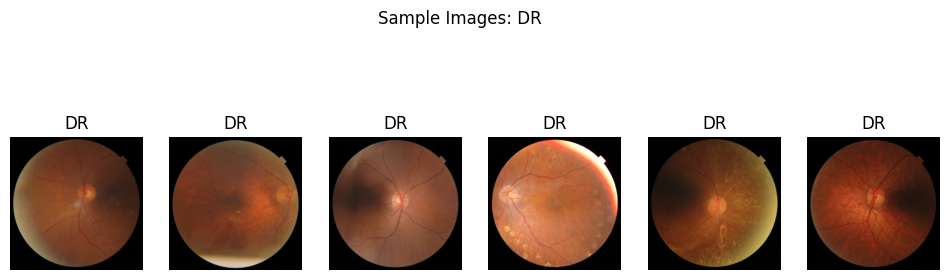

In [32]:

# CLASS DISTRIBUTION AFTER EXPANSION
plt.figure(figsize=(6,4))
sns.countplot(data=train_df, x="label")
plt.xticks([0,1], ["No DR", "DR"])
plt.title("Binary Label Distribution (Expanded Dataset)")
plt.show()

print("\nCounts:")
print(train_df["label"].value_counts())
plt.figure(figsize=(6,4))
sns.countplot(data=train_raw, x="Grade")
plt.title("Original Grade Distribution (Train CSV)")
plt.show()

print(train_raw["Grade"].value_counts())
IMG_SIZE = (300, 300)   # or (299, 299) for Xception
RANDOM_STATE = 42
img_dir = IMG_DIR   # for compatibility

def show_samples(df, label, n=6):
    subset = df[df["label"] == label].sample(
        min(n, len(df[df["label"] == label])),
        random_state=RANDOM_STATE
    )

    plt.figure(figsize=(12,4))
    for i, (_, row) in enumerate(subset.iterrows()):
        img_path = os.path.join(img_dir, row["filename"])
        img = tf.keras.preprocessing.image.load_img(img_path, target_size=IMG_SIZE)
        
        plt.subplot(1, n, i+1)
        plt.imshow(img)
        plt.axis("off")
        plt.title("No DR" if label == 0 else "DR")

    plt.suptitle(f"Sample Images: {'No DR' if label == 0 else 'DR'}")
    plt.show()

# Show samples for both classes
show_samples(train_df, 0)
show_samples(train_df, 1)




#  CLASS BALANCE & CLASS WEIGHTS

In [11]:

print("Label counts train:\n", train_df["label"].value_counts())

classes = np.array([0, 1])
cw = compute_class_weight(
    class_weight="balanced",
    classes=classes,
    y=train_df["label"].values
)
class_weights = {0: cw[0], 1: cw[1]}
print("Class weights:", class_weights)


Label counts train:
 label
1    1036
0     964
Name: count, dtype: int64
Class weights: {0: 1.037344398340249, 1: 0.9652509652509652}


# PREPROCESSING: CLAHE + Xception preprocess

In [12]:

def clahe_xception(img):
    # img arrives as float32 [0,255] or [0,1] depending on generator
    img = img.astype(np.uint8)

    lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.5, tileGridSize=(8,8))
    cl = clahe.apply(l)
    lab = cv2.merge((cl, a, b))
    img = cv2.cvtColor(lab, cv2.COLOR_LAB2RGB)

    img = img.astype(np.float32)
    img = xcep_preprocess(img)   # [-1,1] scaling + channel-wise normalization
    return img


# IMAGE GENERATORS 

In [13]:

train_datagen = ImageDataGenerator(
    preprocessing_function=clahe_xception,
    validation_split=0.2,
    rotation_range=25,
    zoom_range=0.2,
    width_shift_range=0.08,
    height_shift_range=0.08,
    shear_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode="nearest"
)

val_datagen = ImageDataGenerator(
    preprocessing_function=clahe_xception,
    validation_split=0.2
)

test_datagen = ImageDataGenerator(
    preprocessing_function=clahe_xception
)

train_gen = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=IMG_DIR,
    x_col="filename",
    y_col="label",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="raw",      # numeric 0/1
    subset="training",
    seed=SEED
)

val_gen = val_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=IMG_DIR,
    x_col="filename",
    y_col="label",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="raw",
    subset="validation",
    shuffle=False,
    seed=SEED
)

test_gen = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=IMG_DIR,
    x_col="filename",
    y_col="label",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="raw",
    shuffle=False
)


Found 1600 validated image filenames.
Found 400 validated image filenames.
Found 1100 validated image filenames.


# BUILD DUAL-IMAGE-IN-ONE-DATASET XCEPTION MODEL (BINARY)
#    (Standard single-input CNN, but trained on both macula & optic)

In [14]:

tf.keras.backend.clear_session()
gc.collect()

base = Xception(weights="imagenet", include_top=False, input_shape=IMG_SIZE + (3,))
base.trainable = False  # stage 1

inputs = layers.Input(shape=IMG_SIZE + (3,))
x = base(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(512, activation="relu")(x)
x = layers.Dropout(0.4)(x)
x = layers.Dense(128, activation="relu")(x)
output = layers.Dense(1, activation="sigmoid")(x)

model = models.Model(inputs, output)
model.summary()


I0000 00:00:1763650483.588309      48 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1763650483.589048      48 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 299, 299, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ xception (Functional)           │ (None, 10, 10, 2048)   │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,976,361 (83.83 MB)

 Trainable params: 1,114,881 (4.25 MB)

 Non-trainable params: 20,861,480 (79.58 MB)

# FINE-TUNE XCEPTION

In [17]:

base.trainable = True
for layer in base.layers[:-60]:  # unfreeze last 60 layers
    layer.trainable = False

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

cb2 = [
    tf.keras.callbacks.ReduceLROnPlateau(patience=3, factor=0.5, verbose=1),
    tf.keras.callbacks.EarlyStopping(patience=8, restore_best_weights=True, verbose=1)
]

history2 = model.fit(
    train_gen,
    epochs=40,
    validation_data=val_gen,
    class_weight=class_weights,
    callbacks=cb2
)


Epoch 1/40


E0000 00:00:1763651720.555705     151 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1763651720.698097     151 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


100/100 ━━━━━━━━━━━━━━━━━━━━ 96s 724ms/step - accuracy: 0.6435 - loss: 0.6431 - val_accuracy: 0.7250 - val_loss: 0.5481 - learning_rate: 1.0000e-05
Epoch 2/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 71s 706ms/step - accuracy: 0.6991 - loss: 0.5895 - val_accuracy: 0.7475 - val_loss: 0.5116 - learning_rate: 1.0000e-05
Epoch 3/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 70s 703ms/step - accuracy: 0.7214 - loss: 0.5475 - val_accuracy: 0.7625 - val_loss: 0.5028 - learning_rate: 1.0000e-05
Epoch 4/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 69s 689ms/step - accuracy: 0.7235 - loss: 0.5329 - val_accuracy: 0.7600 - val_loss: 0.4922 - learning_rate: 1.0000e-05
Epoch 5/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 70s 694ms/step - accuracy: 0.7076 - loss: 0.5544 - val_accuracy: 0.7800 - val_loss: 0.4946 - learning_rate: 1.0000e-05
Epoch 6/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 73s 730ms/step - accuracy: 0.7130 - loss: 0.5448 - val_accuracy: 0.7800 - val_loss: 0.4883 - learning_rate: 1.0000e-05
Epoch 7/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 71s 712ms/step - 

In [18]:
# =========================================================
# SAVE XCEPTION MODEL in Kaggle
# =========================================================
save_path = "/kaggle/working/xception_dr_model.h5"

model.save(save_path)
print("Model saved successfully to:", save_path)


Model saved successfully to: /kaggle/working/xception_dr_model.h5


# MODEL EVALUATION FUNCTION

In [33]:

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

def evaluate_model(model, test_gen, model_name="Model"):
    print(f"\n===== Evaluating: {model_name} =====")

    # True labels
    y_true = test_gen.labels

    # Predicted probabilities
    y_prob = model.predict(test_gen, verbose=1).ravel()

    # Convert to 0/1
    y_pred = (y_prob >= 0.5).astype(int)

    # Accuracy
    acc = accuracy_score(y_true, y_pred)
    print(f"\n🔥 Test Accuracy ({model_name}): {acc:.4f}\n")

    # Classification report
    print("Classification Report:")
    print(classification_report(y_true, y_pred, digits=4))

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(
        cm, annot=True, fmt="d", cmap="Blues",
        xticklabels=["No DR", "DR"],
        yticklabels=["No DR", "DR"]
    )
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(f"Confusion Matrix - {model_name}")
    plt.show()

    # Return results as dictionary
    return {
        "model": model_name,
        "accuracy": acc,
        "y_true": y_true,
        "y_pred": y_pred,
        "y_prob": y_prob,
        "confusion_matrix": cm
    }



===== Evaluating: Xception Model =====
69/69 ━━━━━━━━━━━━━━━━━━━━ 23s 327ms/step

🔥 Test Accuracy (Xception Model): 0.7473

Classification Report:
              precision    recall  f1-score   support

           0     0.6944    0.8491    0.7640       530
           1     0.8230    0.6526    0.7280       570

    accuracy                         0.7473      1100
   macro avg     0.7587    0.7508    0.7460      1100
weighted avg     0.7611    0.7473    0.7453      1100



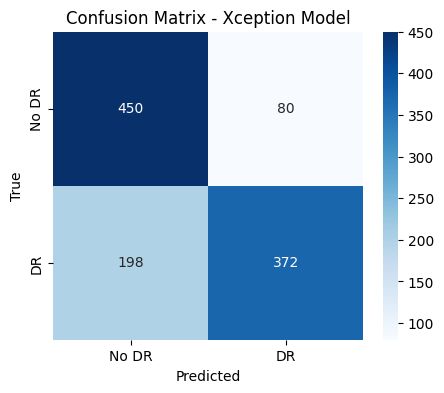

In [34]:
results_xception = evaluate_model(model, test_gen, model_name="Xception Model")


# TRAINING GRAPH FUNCTION

In [35]:

def plot_history(history, model_name="Model"):
    acc = history.history.get("accuracy", [])
    val_acc = history.history.get("val_accuracy", [])
    loss = history.history.get("loss", [])
    val_loss = history.history.get("val_loss", [])

    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(14, 5))

    # Accuracy graph
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, label="Train Accuracy")
    plt.plot(epochs, val_acc, label="Val Accuracy")
    plt.title(f"{model_name} — Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)

    # Loss graph
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, label="Train Loss")
    plt.plot(epochs, val_loss, label="Val Loss")
    plt.title(f"{model_name} — Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)

    plt.show()


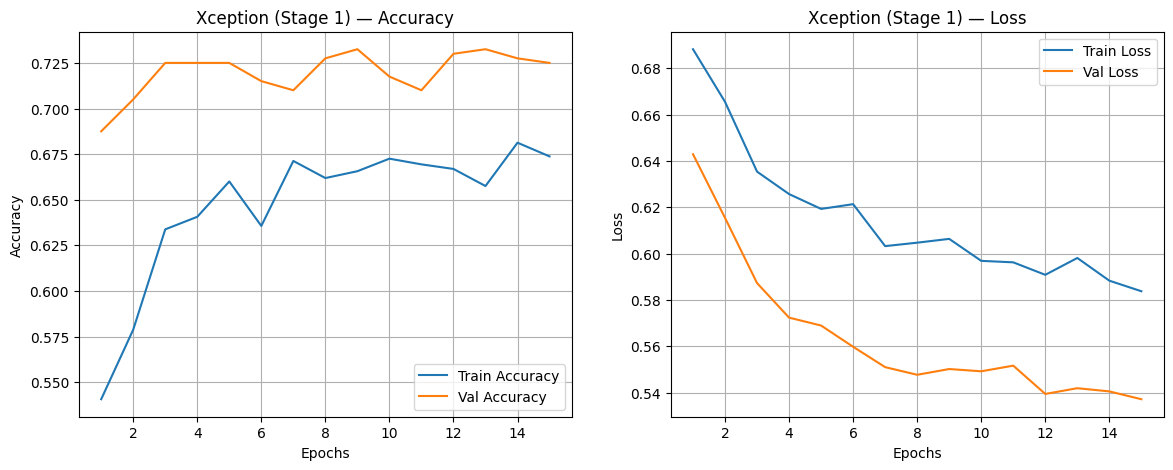

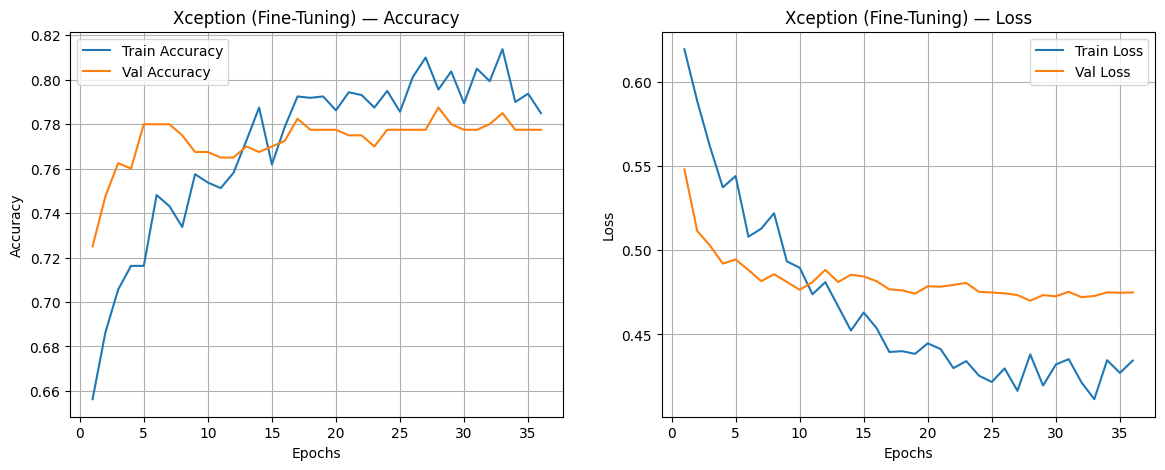

In [36]:
plot_history(history1, "Xception (Stage 1)")
plot_history(history2, "Xception (Fine-Tuning)")


# LOAD XCEPTION MODEL

In [19]:

from tensorflow.keras.models import load_model
from tensorflow.keras.applications.xception import preprocess_input as xcep_preprocess

model_path = "/kaggle/working/xception_dr_model.h5"
xception_model = load_model(model_path, compile=False)

print("Model loaded successfully!")


Model loaded successfully!


# Testing model

In [21]:
import cv2
import numpy as np

IMG_SIZE = (299, 299)

def preprocess_xception_image(img_path):
    img = cv2.imread(img_path)
    if img is None:
        raise ValueError("Image not found: " + img_path)

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, IMG_SIZE)

    # CLAHE
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.5, tileGridSize=(8,8))
    cl = clahe.apply(l)
    lab = cv2.merge((cl, a, b))

    img = cv2.cvtColor(lab, cv2.COLOR_LAB2RGB).astype(np.float32)

    # Xception preprocessing (-1 to 1)
    img = xcep_preprocess(img)

    img = np.expand_dims(img, axis=0)
    return img


In [22]:
def predict_dr_xception(img_path):
    img = preprocess_xception_image(img_path)

    prob = xception_model.predict(img)[0][0]
    label = "DR" if prob >= 0.5 else "No DR"

    print("===================================")
    print("Image:", img_path)
    print("Prediction:", label)
    print("Probability (DR): {:.4f}".format(prob))
    print("===================================")

    return label, prob


In [29]:
test_image = "/kaggle/input/drtid-data/DRTiD/Original Images/0019_1.jpg"
predict_dr_xception(test_image)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Image: /kaggle/input/drtid-data/DRTiD/Original Images/0019_1.jpg
Prediction: DR
Probability (DR): 0.7526


('DR', 0.752636)